# Project Report
### Wine Quality Classification
##### Names: Sean Dempsey, insert names

### Introduction
Wine quality and flavour is a complex topic, and results can be influenced by a multitude of external factors, including the grape variety, climatic conditions of growth, and geographic location (Basalekou et al., 2023). These qualitative factors help to influence the quantitative chemical and physical properties of the wine, such as the acidity, density, and sulphite concentration, among many others. In this project, we hope to use these quantitative elements to classify wines on a ten-point quality scale. To be more specific, we want to know what quantitative wine qualities, such as those mentioned above, can be used to accurately predict the quality of the wine. The dataset being used is the "Wine Quality Dataset" from Kaggle (https://www.kaggle.com/datasets/yasserh/wine-quality-dataset). The dataset focuses on a specific type of red wine called "Vinho Verde", which originates from Portugal. Considering only one region makes classification simpler since geographic location and climate don't have to be factored into the equation. This dataset contains over 1100 observations of different wines in the region, and the variables describe the chemical and physical properties of the wine. The dataset has many variables, and it is likely that not all will be useful for predicting the wine quality. As such, the aim of this project is to determine the best predicting variables for wine quality from this dataset.

### Methods and Results

#### Step 1: Read in and wrangle data
The first step will be to load the required libraries for this analysis.

In [3]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)
install.packages("corrplot")
library(corrplot)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

 The dataset is already quite tidy, but adjustments will be made to remove spaces from the variable names, change the `quality` varibale type from dbl to factor, and remove the unnecessary `id` varibale.

In [24]:
options(repr.matrix.max.rows = 11) # setting the number of rows to print from a data frame 
wine_data <- read_csv("https://raw.githubusercontent.com/MostLeVert/goup01dsci100/main/WineQT.csv") |>
    clean_names() |> # replaces spaces with underscores in varible names
    mutate(quality = as_factor(quality)) |>
    select(-id)
wine_data

Rows: 1143 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
6.8,0.620,0.08,1.9,0.068,28,38,0.99651,3.42,0.82,9.5,6


#### Step 2: Summarize data 
We will first create a table that computes basic statistics for each of the varibales (excluding the predicted class varibale, `quality`). This table will include the mean, max, and min for each variable.

In [26]:
variable_summary <- wine_data |>
    select(-quality) |>
    map_df(mean) |>
    pivot_longer(fixed_acidity:alcohol, names_to = "Variables", values_to = "Mean") |>
    bind_cols(
      pivot_longer(map_df(select(wine_data, -quality), max),
                   fixed_acidity:alcohol, 
                   names_to = "Variables", 
                   values_to = "Maximum" )  
    ) |>
    bind_cols(
      pivot_longer(map_df(select(wine_data, -quality), min),
                   fixed_acidity:alcohol, 
                   names_to = "Variables", 
                   values_to = "Minimum" )  
    ) |>
    mutate(Variable = Variables...1) |>
    select(-Variables...3, - Variables...5, -Variables...1) |>
    select(Variable, Mean, Maximum, Minimum)
variable_summary

New names:
• `Variables` -> `Variables...1`
• `Variables` -> `Variables...3`
New names:
• `Variables` -> `Variables...5`


Variable,Mean,Maximum,Minimum
<chr>,<dbl>,<dbl>,<dbl>
fixed_acidity,8.31111111,15.90000,4.60000
volatile_acidity,0.53133858,1.58000,0.12000
citric_acid,0.26836395,1.00000,0.00000
residual_sugar,2.53215223,15.50000,0.90000
chlorides,0.08693263,0.61100,0.01200
free_sulfur_dioxide,15.61548556,68.00000,1.00000
total_sulfur_dioxide,45.91469816,289.00000,6.00000
density,0.99673041,1.00369,0.99007
p_h,3.31101487,4.01000,2.74000


We can also create a bar plot to visualize the distribution of our class variable, `quality`.

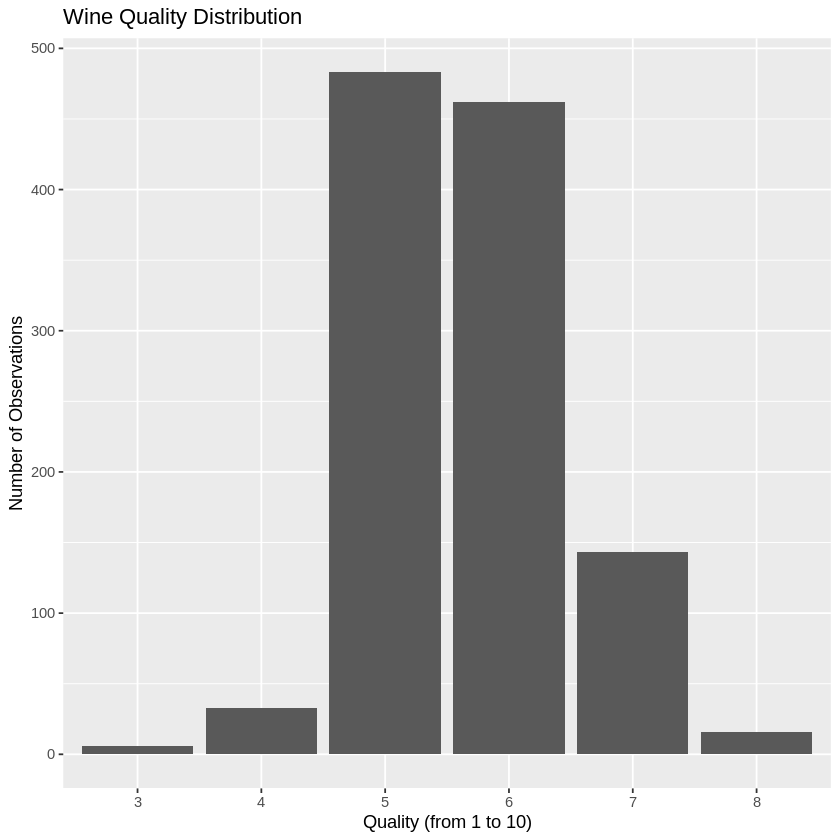

In [29]:
quality_distribution <- wine_data |>
    ggplot(aes(x = quality)) +
        geom_bar() +
        labs(x = "Quality (from 1 to 10)", 
            y = "Number of Observations", 
            title = "Wine Quality Distribution")
quality_distribution

This figure clearly shows that wine quality is not evenly distributed from 1 to 10. Instead, wines with medium quality (5 or 6) are much more common than excellent or terrible wines.

### Discussion

### Reference